# Neural Style Transfer Exp:4
Context [here](https://dhruvs.space/posts/neural-style-transfer/).

Things explored:
- reconstruction of a painting in the style of another painting

See animations on [nbviewer](https://nbviewer.jupyter.org/github/dhth/neural-style-transfer-exps/blob/master/exp_4.ipynb).

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_BASE_PATH = "/content/gdrive/My\ Drive/Colab\ Notebooks/"

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install -q fastai==0.7.0 torchtext==0.2.3

In [0]:
!apt install -q imagemagick

In [0]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
from math import ceil
from decimal import Decimal
from IPython.display import HTML

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [0]:
class NeuralStyleTransfer(object):
    
    def __init__(self,base_model,sz):
        self.base_model = base_model
        self.sz = sz
        self.model = to_gpu(base_model(True)).eval()
        set_trainable(self.model, False)
        self.trn_tfms,self.val_tfms = tfms_from_model(self.base_model, self.sz)
        
    def get_opt(self,img):
        opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
        opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
        opt_img_v = V(self.val_tfms(opt_img/2)[None], requires_grad=True)
        return opt_img_v, optim.LBFGS([opt_img_v])
    
    def step(self,loss_fn):
        self.optimizer.zero_grad()
        loss = loss_fn(self.opt_img_v)
        loss.backward()
        self.n_iter+=1
#         if self.print_losses:
#             if self.n_iter%self.show_iter==0: print(f'Iteration: {self.n_iter}, loss: {loss.data[0]}')
        return loss

    def scale_match(self, src, targ):
        h,w,_ = src.shape
        sh,sw,_ = targ.shape
        rat = max(h/sh,w/sw); rat
        res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
        return res[:h,:w]
    
    def gram(self,input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

    def gram_mse_loss(self,input, target):
        return F.mse_loss(self.gram(input), self.gram(target))
    
    def comb_loss(self,x):
        self.model(self.opt_img_v)
        content_outs = [V(o.features) for o in self.content_sfs]
        style_outs = [V(o.features) for o in self.style_sfs]
        
#         content_loss
        content_losses   = [F.mse_loss(o, s) 
                        for o,s in zip(content_outs, self.targ_vs)]
    
#         style_loss
        style_losses = [self.gram_mse_loss(o, s) 
                        for o,s in zip(style_outs, self.targ_styles)]

    
        if self.content_layers_weights is None:
            content_loss = sum(content_losses)
        else:
            content_loss = sum([a*b for a,b in 
                                zip(content_losses,self.content_layers_weights)])
            
        if self.style_layers_weights is None:
            style_loss = sum(style_losses)
        else:
            style_loss = sum([a*b for a,b in 
                              zip(style_losses,self.style_layers_weights)])
        if self.print_losses:
            if self.n_iter%self.show_iter==0:
                print(f'content: {self.alpha*content_loss.data[0]}, style: {self.beta*style_loss.data[0]}')
        
        if self.return_intermediates and self.n_iter<=self.gif_iter_till:
            if self.n_iter%self.gif_iter==0:
                self.intermediate_images.append(self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0])
        
        return self.alpha*content_loss + self.beta*style_loss

    def generate(self, content_image, style_img,
                 style_layers, content_layers,
                 alpha=1e6,
                 beta=1.,
                 content_layers_weights=None,
                 style_layers_weights=None,
                 max_iter=500,show_iter=300,
                 print_losses=False,
                 scale_style_img=True,
                 return_intermediates=False,
                 gif_iter=50,
                 gif_iter_till=500):
        
        self.max_iter = max_iter
        self.show_iter = show_iter
        self.gif_iter = gif_iter
        self.gif_iter_till = gif_iter_till
        
        self.alpha = alpha
        self.beta = beta
        self.content_layers_weights = content_layers_weights
        self.style_layers_weights = style_layers_weights
        self.print_losses = print_losses
        self.return_intermediates = return_intermediates
        self.intermediate_images = []

        self.content_sfs = [SaveFeatures(children(self.model)[idx]) for idx in content_layers]
        
        self.style_sfs = [SaveFeatures(children(self.model)[idx]) for idx in style_layers]
        
#         get target content
        img_tfm = self.val_tfms(content_image)
        self.opt_img_v, self.optimizer = self.get_opt(content_image)
        self.model(VV(img_tfm[None]))
        self.targ_vs = [V(o.features.clone()) for o in self.content_sfs]

#         get target style
        if scale_style_img:
            style_img = self.scale_match(content_image, style_img)
        self.style_tfm = self.val_tfms(style_img)
        self.model(VV(self.style_tfm[None]))
        self.targ_styles = [V(o.features.clone()) for o in self.style_sfs]
        
        self.n_iter=0

        while self.n_iter <= self.max_iter: self.optimizer.step(partial(self.step,self.comb_loss))
        for sf in self.content_sfs: sf.close()
        for sf in self.style_sfs: sf.close()
        if not self.return_intermediates:
            return self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0]
        else:
            return self.intermediate_images

In [0]:
PATH = Path('data/imagenet')
PATH_IMAGES = PATH/'images'
PATH_STYLE = PATH/'style'

!mkdir -p {PATH_IMAGES}
!mkdir -p {PATH_STYLE}

In [0]:
t2 = NeuralStyleTransfer(vgg16,288)

!wget -qq "https://cdn.shopify.com/s/files/1/0223/4033/products/V495_bfc78f33-3b1a-40ec-bd64-f85c4ec05fa4_1024x1024.jpg" -O data/imagenet/style/van_gogh_self_portrait.jpg
!wget -qq "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/The_Great_Wave_off_Kanagawa.jpg/1024px-The_Great_Wave_off_Kanagawa.jpg" -O data/imagenet/style/kanagawa_wave.jpg
!wget -qq "https://images-na.ssl-images-amazon.com/images/I/81Z7qbHAjDL._SY679_.jpg" -O data/imagenet/style/the_scream.jpg
!wget -qq "http://cdn.artobserved.com/2009/03/vincent-van-gogh-the-night-cafe-1888-via-artstor-collections.jpg" -O data/imagenet/style/the_night_cafe.jpg
!wget -qq "https://raw.githubusercontent.com/jeffxtang/fast-style-transfer/master/images/starry_night.jpg" -O data/imagenet/style/starry_night.jpg


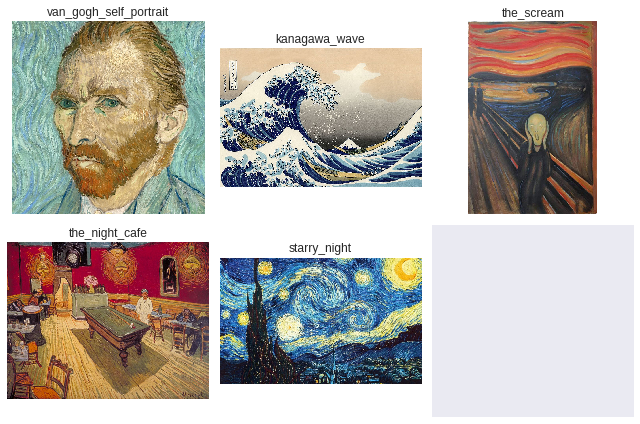

In [10]:
paintings = {
    "van_gogh_self_portrait":"https://cdn.shopify.com/s/files/1/0223/4033/products/V495_bfc78f33-3b1a-40ec-bd64-f85c4ec05fa4_1024x1024.jpg",
    "kanagawa_wave":"https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/The_Great_Wave_off_Kanagawa.jpg/1024px-The_Great_Wave_off_Kanagawa.jpg",
    "the_scream": "https://images-na.ssl-images-amazon.com/images/I/81Z7qbHAjDL._SY679_.jpg",
    "the_night_cafe":"http://cdn.artobserved.com/2009/03/vincent-van-gogh-the-night-cafe-1888-via-artstor-collections.jpg",
    "starry_night": "https://raw.githubusercontent.com/jeffxtang/fast-style-transfer/master/images/starry_night.jpg"
}

for painting in paintings:
    print(f'!wget -qq "{paintings[painting]}" -O {PATH_STYLE}/{painting}.jpg')
    !wget -qq "{paintings[painting]}" -O {PATH_STYLE}/{painting}.jpg
    
style_paintings = []
paintings_names = []

for painting in paintings:
    try:
        style_paintings.append(open_image(f'{PATH_STYLE}/{painting}.jpg'))
        paintings_names.append(painting)
    except Exception as e:
        print(str(e))
        
n_cols = 3
n_rows = ceil(len(style_paintings)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*3,n_rows*3))

for i,ax in enumerate(axes.flat):

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if i==len(paintings_names):
        break
    ax.set_title(f'{paintings_names[i]}')
    ax.imshow(style_paintings[i])
#     ax.imshow(t2.scale_match(content_img, style_paintings[i]))
plt.tight_layout()
plt.show()

## Reconstruction GIFs for 4 paintings

In [0]:
def generate_anim(content_img, style_img,
                   gif_name,
                   content_layers=[16,22,26],
                   style_layers=[9,12,16,22,26],
                   alpha=1e5,
                   beta=3.,
                   style_layers_weights=None,
                   max_iter=800,show_iter=100,
                   print_losses=True,
                   scale_style_img=True,
                   return_intermediates=True,
                   gif_iter=10,
                   gif_iter_till=200):

    imgs = t2.generate(content_img, style_img,
                           content_layers=content_layers,
                           style_layers=style_layers,
                           alpha=alpha,
                           beta=beta,
                           style_layers_weights=style_layers_weights,
                           max_iter=max_iter,show_iter=show_iter,
                           print_losses=print_losses,
                           scale_style_img=scale_style_img,
                           return_intermediates=True,
                           gif_iter=gif_iter,
                           gif_iter_till=gif_iter_till)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.tight_layout()
    ims = []
    for i,img in enumerate(imgs):
        txt = plt.text(10,15,f'{i*gif_iter}',color='white', fontsize=16, weight='bold')
        im = ax.imshow(np.clip(img, 0, 1), interpolation='lanczos', animated=True)

        ims.append([im,txt])

    ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True,
                                repeat=False)
    plt.close()
#     ani.save(gif_name, writer='imagemagick', fps=2)
    return ani

In [0]:
ani0 = generate_anim(style_paintings[0],style_paintings[1],'1',gif_iter_till=250)
HTML(ani0.to_html5_video())

content: 4435.337707400322, style: 18639.6796875
content: 1901.2358039617538, style: 917.4693603515625
content: 1426.7734251916409, style: 529.4200744628906
content: 1251.445896923542, style: 423.6162414550781
content: 1178.4016154706478, style: 391.8284454345703
content: 1145.2672071754932, style: 381.0195007324219
content: 1126.5166103839874, style: 375.8551254272461
content: 1114.4987307488918, style: 372.32361602783203
content: 1105.5422946810722, style: 369.8800964355469


In [0]:
ani0 = generate_anim(style_paintings[0],style_paintings[2],'1',gif_iter_till=250)
HTML(ani0.to_html5_video())

In [0]:
ani0 = generate_anim(style_paintings[0],style_paintings[3],'1',gif_iter_till=250)
HTML(ani0.to_html5_video())

content: 4449.423402547836, style: 48331.388671875
content: 1202.836912125349, style: 333.28255462646484
content: 818.8457228243351, style: 249.79000854492188
content: 726.7196662724018, style: 229.54845428466797
content: 691.2522949278355, style: 219.53599548339844
content: 673.7872958183289, style: 214.06947326660156
content: 663.3215583860874, style: 211.0059585571289
content: 656.1249494552612, style: 209.04867553710938
content: 650.9315688163042, style: 207.59005737304688


In [11]:
t2 = NeuralStyleTransfer(vgg16,288)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:18<00:00, 29480670.49it/s]


In [0]:
def painting_to_paintings(paintings,paintings_names,
                         content_index,
                         n_cols=2,
                         alpha=1e5,
                         beta=1.):
    n_cols = n_cols
    
    paintings = paintings.copy()
    paintings_names = paintings_names.copy()
    content_painting = paintings.pop(content_index)
    content_painting_name = paintings_names.pop(content_index)
    
    n_rows = ceil(len(paintings)/n_cols)
    fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

    for i,ax in enumerate(axes.flat):
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

        if i==len(paintings):
            break
        
        print(f'Generating {content_painting_name} in style of : {paintings_names[i]}...')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{paintings_names[i]}')
        gen4 = t2.generate(content_painting, paintings[i],
                           content_layers=[19,22],
                           style_layers=[9,12,16,22,],
                           alpha=alpha,
                           beta=beta,
                           max_iter=1000,show_iter=100,
                           print_losses=True)

        x = np.clip(gen4, 0, 1)
        ax.imshow(x,interpolation='lanczos')
    plt.tight_layout()   
    fig_name = f'v2-painting-to-painting-{content_painting_name}.png'
    plt.savefig(fig_name)
    plt.show()
#     !cp {fig_name} {DRIVE_BASE_PATH}saved_models/fai_part_2/lec13/

Generating van_gogh_self_portrait in style of : kanagawa_wave...
content: 3444.53789293766, style: 24607.443359375
content: 1187.230832874775, style: 773.498291015625
content: 938.1994605064392, style: 506.472412109375
content: 842.1060629189014, style: 425.4705505371094
content: 790.2818731963634, style: 385.5163269042969
content: 758.6882449686527, style: 360.9400329589844
content: 738.5133299976587, style: 346.7642822265625
content: 724.7776258736849, style: 337.1562805175781
content: 713.858800008893, style: 329.8197937011719
content: 705.7765498757362, style: 323.5234375
content: 698.8350301980972, style: 318.2950439453125
Generating van_gogh_self_portrait in style of : the_scream...
content: 3449.7439861297607, style: 6126.783203125
content: 827.9182016849518, style: 460.61151123046875
content: 665.6579673290253, style: 321.62261962890625
content: 590.4017016291618, style: 261.9524841308594
content: 553.7280347198248, style: 240.99325561523438
content: 535.816140472889, style: 23

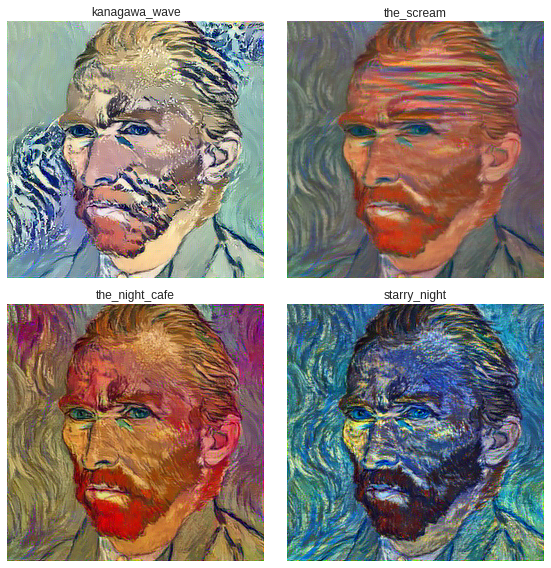

In [0]:
painting_to_paintings(style_paintings,paintings_names,0)

Generating kanagawa_wave in style of : van_gogh_self_portrait...
content: 4188.978672027588, style: 13638.7626953125
content: 627.6045925915241, style: 211.116943359375
content: 472.671864554286, style: 143.860107421875
content: 435.84383092820644, style: 137.12879943847656
content: 419.9373535811901, style: 135.2233123779297
content: 411.13803163170815, style: 134.29307556152344
content: 405.14119900763035, style: 133.66818237304688
content: 400.96999146044254, style: 133.18434143066406
content: 397.8057764470577, style: 132.96316528320312
content: 395.2564671635628, style: 132.76715087890625
content: 393.1809216737747, style: 132.61065673828125
Generating kanagawa_wave in style of : the_scream...
content: 4228.140041232109, style: 8223.6796875
content: 1457.3419466614723, style: 855.2060546875
content: 1247.1307069063187, style: 597.2380981445312
content: 1161.7702431976795, style: 494.06121826171875
content: 1115.6490072607994, style: 437.3471984863281
content: 1087.2410610318184, s

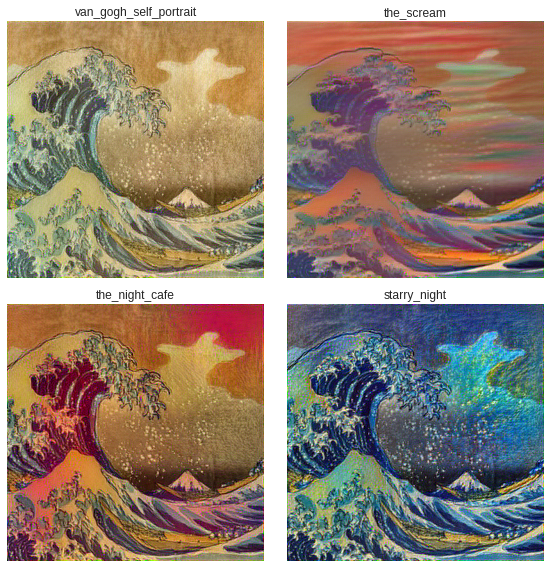

In [13]:
painting_to_paintings(style_paintings,paintings_names,1)

Generating the_scream in style of : van_gogh_self_portrait...
content: 4061.8348866701126, style: 12500.6044921875
content: 380.2096238359809, style: 265.7469787597656
content: 260.3891771286726, style: 126.22727966308594
content: 235.6204902753234, style: 113.86302185058594
content: 226.30211897194386, style: 110.2946548461914
content: 221.11053112894297, style: 108.47270202636719
content: 217.76622161269188, style: 107.36680603027344
content: 215.37011489272118, style: 106.58968353271484
content: 213.45852874219418, style: 105.99275970458984
content: 211.91248670220375, style: 105.52700805664062
content: 210.65771579742432, style: 105.06515502929688
Generating the_scream in style of : kanagawa_wave...
content: 4108.378663659096, style: 25742.767578125
content: 1482.2371304035187, style: 826.8190307617188
content: 1136.5393176674843, style: 558.6441650390625
content: 1008.3353146910667, style: 474.57647705078125
content: 935.0315667688847, style: 431.76800537109375
content: 892.155058

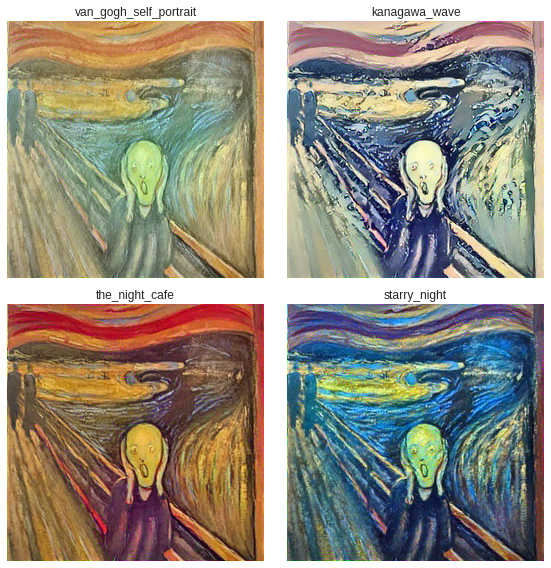

In [14]:
painting_to_paintings(style_paintings,paintings_names,2)

In [0]:
painting_to_paintings(style_paintings,paintings_names,3)

In [0]:
 painting_to_paintings(style_paintings,paintings_names,4)